In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd

# IMAGE DATA HANDLING

In [2]:
training_path = r"C:\Users\Rahul\OneDrive\Desktop\projects\datasets\sartajbhuvaji\brain-tumor-classification-mri\versions\2\Training"
testing_path = r"C:\Users\Rahul\OneDrive\Desktop\projects\datasets\sartajbhuvaji\brain-tumor-classification-mri\versions\2\Testing"

In [3]:
#FUNCTION TO EXTRACT DATA

def path_to_df(dir_path):
    data = pd.DataFrame(columns=["label","image_array"])
    list_training_data = os.listdir(dir_path)
    target_size = (128,128)
    for i in list_training_data:
        path_i = os.path.join(dir_path,i)
        for j in os.listdir(path_i):
            full_path = os.path.join(path_i,j)
            image = Image.open(full_path).convert('L') #converting image to greyscale
            image = image.resize(target_size)          #changing image size
            image_array = np.array(image)              #converting to numpy array
            new_row = pd.DataFrame({"label":i,"image_array":[image_array]})
            data = pd.concat([data,new_row],ignore_index = True)
    return data

In [4]:
training_data = path_to_df(training_path)

In [5]:
testing_data = path_to_df(testing_path)

In [6]:
#shuffling data
training_data = training_data.sample(len(training_data),ignore_index=True)
testing_data = testing_data.sample(len(testing_data),ignore_index=True)

In [7]:
#normalising data
training_data["image_array"] = training_data["image_array"]/255
testing_data['image_array'] = testing_data['image_array']/255


In [8]:
training_data.shape

(2870, 2)

In [9]:
testing_data.shape

(394, 2)

meningioma_tumor


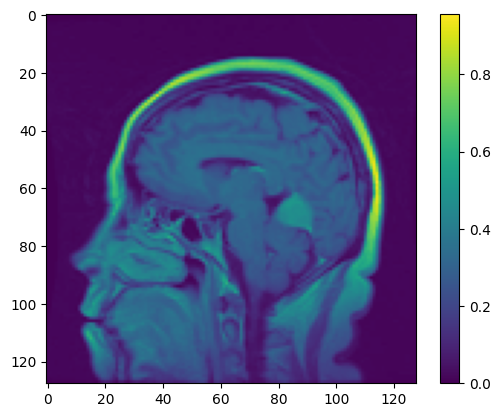

In [10]:
print(training_data['label'][49])
plt.imshow(training_data['image_array'][49])
plt.colorbar()

pituitary_tumor


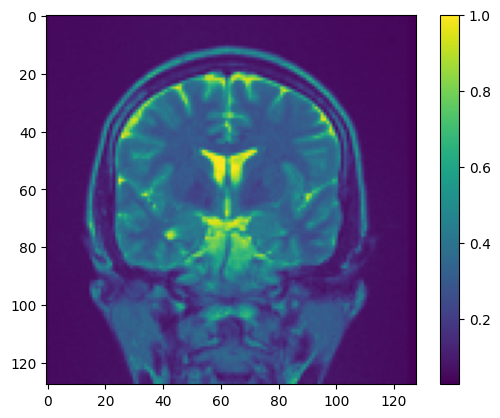

In [11]:
print(testing_data['label'][3])
plt.imshow(training_data['image_array'][3])
plt.colorbar()

# DEFINING MODELS

In [12]:
#CNN model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input,Conv2D, MaxPooling2D, Flatten, Dense, Dropout

def build_cnn_model_1(input_shape, num_classes):
    model = Sequential([
        Input(shape=input_shape),
        Conv2D(32, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

def build_cnn_model_2(input_shape, num_classes):
    model = Sequential([
        Input(shape=input_shape),
        Conv2D(16, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(32, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

### CROSS VALIDATION ON TRAINING SET

In [13]:
from sklearn.model_selection import StratifiedKFold

X = np.stack(training_data['image_array'].values)
X = X[..., np.newaxis]
y = training_data['label'].values

skf = StratifiedKFold(n_splits=5,shuffle=True,random_state=42)

In [14]:
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_encoded = le.fit_transform(y)
y_categorical = to_categorical(y_encoded)

In [15]:
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

# Encode labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)
y_categorical = to_categorical(y_encoded)

def validate_and_record(model_input):
    for train_index, val_index in skf.split(X, y_encoded):
        
        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = y_categorical[train_index], y_categorical[val_index]
    
        # Build CNN model
        model = model_input(input_shape=X[0].shape, num_classes=4)  # Define this function
        
        # Train model
        model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=32)
        
        # Evaluate or store results
        val_loss, val_acc = model.evaluate(X_val, y_val)
        print(f"Validation accuracy: {val_acc:.4f}")


In [16]:
validate_and_record(build_cnn_model_1)
print("")
validate_and_record(build_cnn_model_2)

Epoch 1/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 37s 265ms/step - accuracy: 0.4789 - loss: 1.1356 - val_accuracy: 0.7369 - val_loss: 0.6672
Epoch 2/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 30s 250ms/step - accuracy: 0.7626 - loss: 0.5840 - val_accuracy: 0.7578 - val_loss: 0.5506
Epoch 3/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 21s 289ms/step - accuracy: 0.8174 - loss: 0.4466 - val_accuracy: 0.7979 - val_loss: 0.4524
Epoch 4/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 18s 252ms/step - accuracy: 0.8865 - loss: 0.3051 - val_accuracy: 0.8624 - val_loss: 0.3722
Epoch 5/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 18s 248ms/step - accuracy: 0.9127 - loss: 0.2216 - val_accuracy: 0.8659 - val_loss: 0.3454
Epoch 6/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 19s 260ms/step - accuracy: 0.9447 - loss: 0.1683 - val_accuracy: 0.8868 - val_loss: 0.3065
Epoch 7/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 18s 244ms/step - accuracy: 0.9550 - loss: 0.1244 - val_accuracy: 0.8746 - val_loss: 0.3361
Epoch 8/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 18s 245ms/step - accuracy: 0.9514 - loss: 0.1256 - val_accu

In [17]:
val_acc_list = [['model_1',0.9024],['model_2',0.9024]]